Machine Learning Pipeline Nedir? 🚀

Machine Learning Pipeline (Makine Öğrenmesi Boru Hattı), veri işleme ve modelleme adımlarını belirli bir sıraya koyarak otomatikleştiren bir sistemdir.
Bu, veri temizleme, dönüştürme, özellik mühendisliği, model eğitimi ve değerlendirme gibi adımları içerir.
📌 Pipeline Adımları:
1️⃣ Veri Ön İşleme (Preprocessing)

    Eksik değerleri doldurma (imputation)
    Kategorik değişkenleri sayısala çevirme (one-hot encoding, label encoding)
    Ölçeklendirme / Normalizasyon (StandardScaler, MinMaxScaler)

2️⃣ Özellik Mühendisliği (Feature Engineering)

    Gereksiz değişkenleri çıkarma
    Yeni değişkenler oluşturma
    Özellik seçimi (Feature Selection)

3️⃣ Model Eğitimi ve Optimizasyon

    Veriyi eğitim-test olarak ayırma
    Farklı algoritmalarla model oluşturma
    Hiperparametre optimizasyonu (GridSearchCV, RandomizedSearchCV)

4️⃣ Model Değerlendirme

    Performans metrikleri ile değerlendirme (Accuracy, RMSE, F1-Score, ROC-AUC)
    Overfitting veya underfitting olup olmadığını analiz etme

5️⃣ Model Deploy (Dağıtım)

    Gerçek hayatta kullanılabilir hale getirme (FastAPI, Flask, TensorFlow Serving)

In [81]:
################################################
# End-to-End Diabetes Machine Learning Pipeline I
################################################

# 1. Exploratory Data Analysis
# 2. Data Preprocessing & Feature Engineering
# 3. Base Models
# 4. Automated Hyperparameter Optimization
# 5. Stacking & Ensemble Learning
# 6. Prediction for a New Observation
# 7. Pipeline Main Function

import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [82]:
def check_df(dataframe, head=5): # adı üstünde incelemek için verilere bakılır
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):# kategorik değişkenin sınıf frekansını ve oranını veriyor
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False): # temel sayısal istatistikleri hesaplar
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col): # bağımlı değişkeni sayısal bir değişkenle özetlemek için
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):# bağımlı değişkeni kategorik değişkene göre özetliyor
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols): # sayısal değişkenlerin korelasyon matrisini hesaplıyor
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627

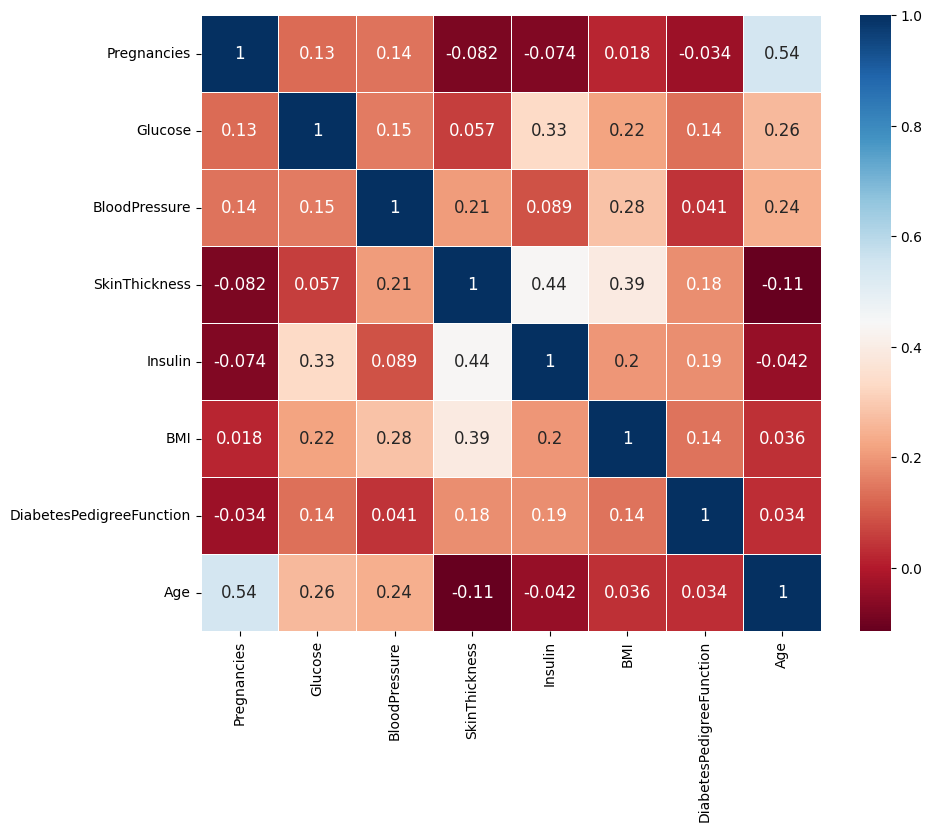

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




In [83]:
df = pd.read_csv("datasets/diabetes.csv")

check_df(df)


# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

# for col in num_cols:
#     num_summary(df, col, plot=True)

# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

bu fonksiyonlar ile verisetini incelemek gerekir kimin ne ile korelasyonu var aykırı değeri ne yapmalıyım anormal değer varmı gibisinden

In [84]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75): # aykırı değer tanımı
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable): # alt üst limitlerle aykırı değeri kontrol et
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75): # aykırı değer varmı
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False): # adı üstüne
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [85]:
# Değişken isimleri büyütelimki sonradan okurken karışıklık çıkmasın
df.columns = [col.upper() for col in df.columns]

In [86]:
# diyabet glukoz ile aşırı bağlantılı olduğundan belirlediğim aralıktaki değerlere etiketleme yapıyorum
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"]) # 0 ıda kapsasın diye -1 yazdık
# 0 ile 139 arası normal 
# 139 200 arası prediabet   şeklinde yeni değişken ürettik ama varolan glucose değişkenini silmemeliyiz
# bizim oluşturduğumz yeni değişken zaten halihazırda glucose değişkeni kadar bilgi taşımıyor makina modelleri için
# yani ağaç yöntemlerinde bize sorun çıkartabilir homojenliği bozuyor olabilir 
# o yüzden şimdilik dursun ilerleyen aşamalarda karar verilir

# aynı mantıkla yeni değişken türetmeye devam edelim

# Age içinde aynı şekilde genç orta yaş yaşlı şeklinde ayırdık
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'


# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healty", "overweight", "obese"])

# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])
# hs1 hs2 teknik isimlendirme

# ve yeni değişkenlere tekrar bakmak istersek
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# inceleyelim

In [87]:
for col in cat_cols:
    cat_summary(df, col) # yeni oluşturduğumuz değişkenleri inceleyelim
# hangi değişkenden kaçar tane var ve oranları neler


             NEW_AGE_CAT      Ratio
NEW_AGE_CAT                        
young                488  63.541667
middleage            230  29.947917
old                   50   6.510417
##########################################
         OUTCOME      Ratio
OUTCOME                    
0            500  65.104167
1            268  34.895833
##########################################
                 NEW_GLUCOSE_CAT      Ratio
NEW_GLUCOSE_CAT                            
normal                       571  74.348958
prediabetes                  197  25.651042
##########################################
               NEW_BMI_RANGE      Ratio
NEW_BMI_RANGE                          
obese                    472  61.458333
overweight               179  23.307292
healty                   102  13.281250
underweight               15   1.953125
##########################################
                   NEW_BLOODPRESSURE      Ratio
NEW_BLOODPRESSURE                              
normal                  

In [88]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)
# şimdide bu yeni değişkenlerin hedef değişkenle karşılaştırmalarına bakalım
# çıktıdaki target şuan outcome(diyabetmi değilmi)

# mesela orta yaşlı kişilerin yüzde 54 ü diyabetliymiş
# yada normal glikoze seviyesine sahip kişilerin sadece yüzde 23ü diyabet hastası imiş

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




/tmp/ipykernel_1769850/50249637.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
/tmp/ipykernel_1769850/50249637.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
/tmp/ipykernel_1769850/50249637.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

In [89]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col] # outcome artık bağımlı değişkenimiz olduğundan cat cols dan çıkartalım
cat_cols

['NEW_AGE_CAT', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

In [90]:
# Makine öğrenmesi modelleri, veriyi sayısal olarak işlemesini bekler. Kategorik değişkenler modelin anlayabileceği şekilde 
# binary encoding (one-hot encoding) veya sayısal temsillerle dönüştürülmelidir.

# Ancak bazı sıralı (ordinal) kategorik değişkenler zaten büyüklük-küçüklük ilişkisi taşıdığı için olduğu gibi bırakılabilir. Örneğin:
#     NEW_AGE_CAT → "young" < "middleage" < "old" (Yaş büyüdükçe diyabet riski değişebilir)
#     NEW_GLUCOSE_CAT → "normal" < "prediabetes" (Glukoz seviyesi arttıkça risk artıyor)
#     NEW_BMI_RANGE → "underweight" < "healthy" < "overweight" < "obese" (BMI yükseldikçe obezite riski artıyor)
#     NEW_BLOODPRESSURE → "normal" < "hs1" < "hs2" (Kan basıncı yükseldikçe hipertansiyon riski artıyor)

# Bu değişkenler belli bir sıralama içerdiği için, model büyüklük ilişkisini öğrenebilir.
# Bu yüzden sayısal kodlama (label encoding: 0,1,2,3 gibi) ile bırakılabilir ve one-hot encoding gibi yöntemler uygulanmasına gerek yoktur.

# Eğer kategori sıralı değilse, yani büyüklük-küçüklük ilişkisi yoksa
# (örneğin "şehir", "renk" gibi), o zaman one-hot encoding kullanmak gerekir.

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.columns = [col.upper() for col in df.columns] # tekrar büyütüyoruz çünkü one hot encodingden sonra yeni gelenler küçük harfle yazılmış

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20) # son gelen değişkenleri tekrar grab_col_names e verelim
cat_cols = [col for col in cat_cols if "OUTCOME" not in col] # yine bağımlıyı cat colstan atalım

In [91]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95)) # çok değişkenli yapı olduğundan sadece aşırı aykırılıkları atmak istiyorum

# çıktıda sadece insülinde aykırı değer tespit ettik
# aykırı belirlediğimiz alt üst limite eşitleyelim
replace_with_thresholds(df, "INSULIN")

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


/tmp/ipykernel_1769850/1400016224.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [92]:
# Standartlaştırma
# yinede standardize edelim zararı yok zaten model denemesi yaparken elimizi hızlandırır
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns) # normalde veriseti bozulduğu için direkt df e atamak yerine
# kopya df oluşturmak daha güvenlidir mesela df_scaled = pd.DataFrame(X_scaled, columns=num_cols) böyle

In [93]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

check_df(X[num_cols]) # ön kontrol için (booleanları almadık çünkü check_df numerik istiyor hata veriyor)

##################### Shape #####################
(768, 8)
##################### Types #####################
PREGNANCIES                 float64
GLUCOSE                     float64
BLOODPRESSURE               float64
SKINTHICKNESS               float64
INSULIN                     float64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                         float64
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.787602  0.204013   
1    -0.844885 -1.123396      -0.160546       0.530902 -0.787602 -0.684422   
2     1.233880  1.943724      -0.263941      -1.288212 -0.787602 -1.103255   
3    -0.844885 -0.998208      -0.160546       0.154533  0.217583 -0.494043   
4    -1.141852  0.504055      -1.504687       0.907270  1.008900  1.409746   

   DIABETESPEDIGREEFUNCTION       AGE  
0                  0.468492  1.

In [94]:
# bu yaptığımız şeyleri tek bir fonksiyonada dökebiliriz
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [ ]:
# modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")
# modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") 
# modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy") # modellere sorduğumuz bölüm burası ve bu kısım normalde pipline da olmaz
# burası acaba hangi model ne kadar başarılı olur sorusuna bir ön fikir veriyor
# ön fikir dememin sebebi mesela knn yüksek çıkar ama gerçekte xgboost hiperparametre ile daha yüksek çıkabilir gibi şeyler

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), # parametreler warningleri önlemek için 
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))bu çok uzun sürüyor atlayalım
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

#base_models(X, y, scoring="accuracy") 
# her türlü metriği buradan deneyebiliriz

In [96]:
# hiperparametre optimizasyonlarını otomatikleştirmek



#----------------------------------------------------------------
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}
#----------------------------------------------------------------



classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]


# verdiğimiz aralıklar küçük olduğu için yinede tam güvenilmez
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    """ hiperparametre optimizasyonundan öncesi değerlerine bakıyoruz
        sonra optimizasyonu gerçekleştiriyoruz gridsearchcv kullandık
        daha sonra en iyi parametreyi bulup final modele yerleştiriyoruz
        ve optimizasyon sonrası skorlarla karşılaştırıyoruz
    """
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6512
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8224


/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~

roc_auc (After): 0.833
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 300}

########## XGBoost ##########


/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


roc_auc (Before): 0.8008


/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/nocturne/VSCode_projeler/ml_ders_3_miuul/.venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [16:12:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

roc_auc (After): 0.8147
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
[LightGBM] [Info] Number of positive: 178, number of negative: 334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347656 -> initscore=-0.629357
[LightGBM] [Info] Start training from score -0.629357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [97]:
######################################################
# 5. Stacking & Ensemble Learning
######################################################

# burada ise yukarıdakinden farklı olarak modellerin en iyi oldukları yönlere göre birleştirilmiş model oluşturuyoruz
# votingclassifier modellerin en güçlü olduğu yönlerden birleştirmeye çalışıyor
# voting="hard" parametresi default olarak gelir ve 
# örneğin 3 modelimiz var ikisi 1 dedi biri 0 dedi ozaman çoğunluğa göre davranır ve 1 i alır
# soft ise olasılıkları alıyor mesela 2 model var biri A değerine %60, B değerine %40 vermiş diğeri A ya %20, B ye %80 vermiş
# B ye olasılıksal olarak daha fazla verildiği için soft değeri B yi alır

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)


Voting Classifier...
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
# modeli artık kaydedip sonra biryerlerde kullanmak için


######################################################
# 6. Prediction for a New Observation
######################################################

X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

joblib.dump(voting_clf, "voting_clf2.pkl") # kaydeder

new_model = joblib.load("voting_clf2.pkl") # kaydedilmişi yükler
new_model.predict(random_user)


In [ ]:
# mesela herşeyi hazırladık fakat elimize aynı türde başka bir diyabet csv geldi yine tüm veriyi işlemeye gerek yok

from diabetes_pipeline import diabetes_data_prep # bu dosyayı yeni verinin geleceği dosyaya importla

X, y = diabetes_data_prep(df) # bu fonksiyonu çağır yeterli

random_user = X.sample(1, random_state=50)

new_model = joblib.load("voting_clf.pkl")

new_model.predict(random_user)